# Job Status Classification Model

Will create a text classification model which classifies job-related emails as either rejection, just-applied, or action-needed.

</br>

- Import libraries and data
- Perform Exploratory Data Analysis (EDA)
- Preprocess the data
- Create and train the model
- Evaluate the model

</br></br>

---

### Import Libraries and Data

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import spacy
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from nltk.corpus import stopwords
from gensim.models.keyedvectors import KeyedVectors
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [142]:
corpus = pd.read_csv("Email-Data.csv")

In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
!gdown "https://drive.google.com/uc?id=1BpfbHu4denceXiv8yfdY3EHgjKIcULku"
embedding_file = './GoogleNews-vectors-negative300.bin.gz'

</br></br>

---

</br></br>

### EDA

In [143]:
corpus.head(10)

,Email,Company,Status,Job_Related
0,Thank you for applying to the Junior Software ...,MSC Technology,reject,Yes
1,Thank you for your interest in the Train To Hi...,Train To Hire,reject,Yes
2,Thank you for your interest in Exyn and for ap...,Exyn,reject,Yes
3,Thank you for your interest in the Software En...,Lantana Consulting Group,reject,Yes
4,Thank you for your interest in PathAI! Unfortu...,PathAI,reject,Yes
5,Thank you for taking the time to apply for our...,Chewy,reject,Yes
6,Thank you for your interest in the Entry Level...,ProSearch,reject,Yes
7,Thank you for your interest in the Software En...,Shields Health Solutions,reject,Yes
8,Thanks for your interest in the Software Engin...,Concinnate Solutions,reject,Yes
9,Thank you for your interest in the Software En...,"Silicon Integration Initiative, Inc",reject,Yes


In [144]:
print("Reject: \n",corpus[corpus['Status'] == 'reject']['Email'].iloc[0],"\n\n\n")
print("Action Needed: \n",corpus[corpus['Status'] == 'action_needed']['Email'].iloc[0],"\n\n\n")
print("Just Applied: \n",corpus[corpus['Status'] == 'just_applied']['Email'].iloc[0],"\n\n\n")

Reject: 
 Thank you for applying to the Junior Software Developer position at MSC Technology.
Unfortunately, MSC Technology has moved to the next step in their hiring process, and your application was not selected at this time. 



Action Needed: 
 As part of your application to Entry Level Back End Developer: 2021, we recently invited you to complete our Coding Assessment.

We wanted to let you know that your responses have been received and are being considered, along with other information from your application process, to determine next steps. These next steps may include being invited to complete another assessment or invitation to an interview.

Please note that if you did not just complete an assessment, this means that your responses were returned from a prior application to IBM and completion of the same assessment. As your assessment responses remain valid for 12 months, there is no need to retake this assessment at this time.

IBM Assessment Team 



Just Applied: 
 Thank yo

Text(0.5, 1.0, 'Counts by Label')

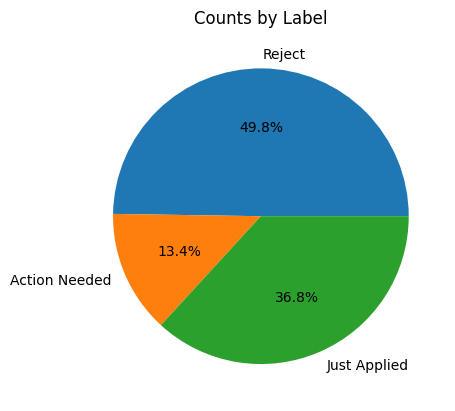

In [145]:
nj, rej, apl, act  = corpus['Status'].value_counts().values
plt.pie(labels=["Reject", "Action Needed", "Just Applied"],
        x=[rej, act, apl], autopct='%1.1f%%')
plt.title("Counts by Label")

*Significantly fewer number of "Action Needed" emails*

In [146]:
def count_words(doc):
  return len(doc.split())

def word_lengths(doc):
  return np.mean([len(s) for s in doc.split()])


doc_lengths = corpus['Email'].apply(len).values
doc_words = corpus['Email'].apply(count_words).values

rej_df = corpus[corpus['Status'] == 'reject']
rej_len = rej_df['Email'].apply(len).values
rej_words = rej_df['Email'].apply(count_words).values
rej_wlen = rej_df['Email'].apply(word_lengths).values

act_df = corpus[corpus['Status'] == 'action_needed']
act_len = act_df['Email'].apply(len).values
act_words = act_df['Email'].apply(count_words).values
act_wlen = act_df['Email'].apply(word_lengths).values

ja_df = corpus[corpus['Status'] == 'just_applied']
ja_len = ja_df['Email'].apply(len).values
ja_words = ja_df['Email'].apply(count_words).values
ja_wlen = ja_df['Email'].apply(word_lengths).values

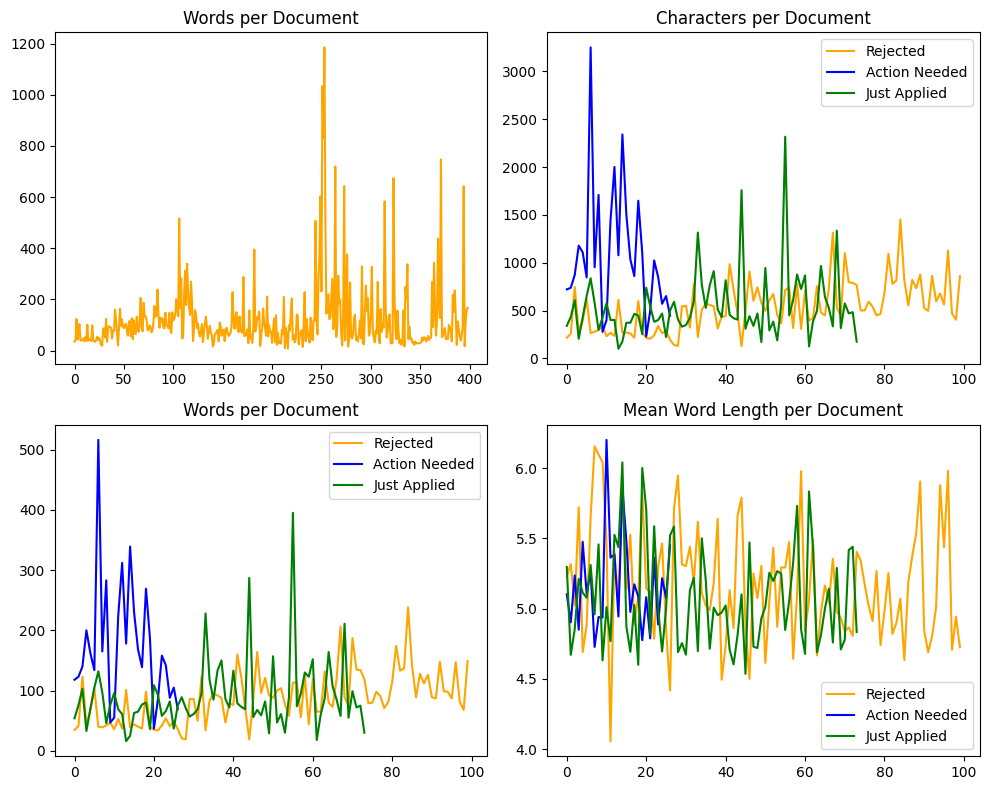

In [147]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(doc_words, color='orange')
plt.title('Words per Document')

plt.subplot(2, 2, 2)
plt.plot(rej_len, color='orange', label='Rejected')
plt.plot(act_len, color='blue', label='Action Needed')
plt.plot(ja_len, color='green', label='Just Applied')
plt.title('Characters per Document')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(rej_words, color='orange', label='Rejected')
plt.plot(act_words, color='blue', label='Action Needed')
plt.plot(ja_words, color='green', label='Just Applied')
plt.title('Words per Document')
plt.legend()


plt.subplot(2, 2, 4)
plt.plot(rej_wlen, color='orange', label='Rejected')
plt.plot(act_wlen, color='blue', label='Action Needed')
plt.plot(ja_wlen, color='green', label='Just Applied')
plt.title('Mean Word Length per Document')
plt.legend()

plt.tight_layout()

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [149]:
def split_doc(doc):
  return [i for i in doc.split() if i.lower() not in stop_words]

rej_counts = Counter(np.concatenate(rej_df['Email'].apply(split_doc).values))
rej_arr = np.array(sorted([(rej_counts[i], i) for i in rej_counts]))[::-1]

act_counts = Counter(np.concatenate(act_df['Email'].apply(split_doc).values))
act_arr = np.array(sorted([(act_counts[i], i) for i in act_counts]))[::-1]

ja_counts = Counter(np.concatenate(ja_df['Email'].apply(split_doc).values))
ja_arr = np.array(sorted([(ja_counts[i], i) for i in ja_counts]))[::-1]

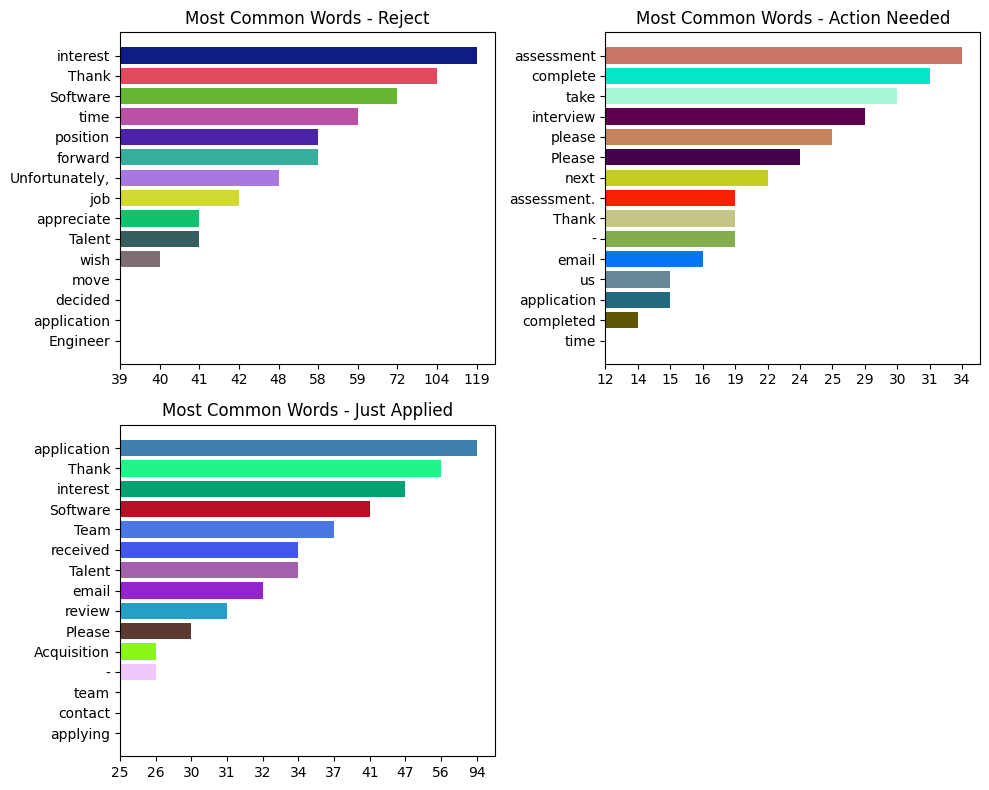

In [150]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.barh(y=rej_arr[:15:,1][::-1], width=rej_arr[:15:,0][::-1],
         color=np.random.rand(15, 3))
plt.title("Most Common Words - Reject")

plt.subplot(2, 2, 2)
plt.barh(y=act_arr[:15:,1][::-1], width=act_arr[:15:,0][::-1],
         color=np.random.rand(15, 3))
plt.title("Most Common Words - Action Needed")

plt.subplot(2, 2, 3)
plt.barh(y=ja_arr[:15:,1][::-1], width=ja_arr[:15:,0][::-1],
         color=np.random.rand(15, 3))
plt.title("Most Common Words - Just Applied")

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

</br></br>

---

</br></br>

### Preprocessing

</br>

Preprocessing Pipeline:
- Encode labels in data
- Shuffle data
- Tokenize Emails
- Create embeddings

</br>

Here is a [useful paper](https://arxiv.org/pdf/1904.08067.pdf)


In [ ]:
corpus = corpus[corpus['Job_Related'] == 'Yes']
corpus.drop(['Job_Related', 'Company'], axis=1, inplace=True)

In [152]:
corpus['Status'] = corpus['Status'].replace(to_replace='reject', value=0)
corpus['Status'] = corpus['Status'].replace(to_replace='action_needed', value=1)
corpus['Status'] = corpus['Status'].replace(to_replace='just_applied', value=2)

Encodes labels as:
- Reject: 0
- Action Needed: 1
- Just Applied: 2

</br></br>


In [153]:
#shuffle data
np.random.seed(42)
corpus = corpus.iloc[np.random.permutation(corpus.index)].reset_index(drop=True)

In [154]:
#new data
corpus.head()

,Email,Status
0,Thanks for applying to ZipRecruiter! At this t...,0
1,Thank you for your interest in the iOS Develop...,0
2,Thank you for giving us the opportunity to con...,0
3,We've received your application for our Softwa...,2
4,Thank you for your interest in Scribd! We have...,2


Data has been cleaned, now to tokenize the emails:

- Case folding
- remove non-word text like urls
- remove punctuation
- remove spaces
- remove stop words
- lemitization
- maybe SMOTE

In [155]:
nlp = spacy.blank('en')


class Preprocessor:

  def __init__(self):
    self.word_dict = {}
    self.words = 0


  def preprocess(self, doc):
    tokens = [t.lower_ for t in nlp(doc) if
                        not t.is_stop and
                        not t.is_punct and
                        t.is_alpha]

    reg = re.compile(r'http\S+|www\.\S+|ftp://\S+')
    tokens = [t for t in tokens if not reg.search(t)]

    return tokens


  def tokenize(self, doc):
    for word in doc:
      if word not in self.word_dict:
        self.word_dict[word] = self.words
        self.words += 1

    return [self.word_dict[word] for word in doc]

In [156]:
text_preprocessor = Preprocessor()

string = """The curious cat gracefully leapt
            onto the sunlit windowsill, casting a watchful gaze over
            the bustling street below."""

tokens = text_preprocessor.preprocess(string)
print(tokens)

['curious', 'cat', 'gracefully', 'leapt', 'sunlit', 'windowsill', 'casting', 'watchful', 'gaze', 'bustling', 'street']


In [157]:
text_preprocessor.tokenize(tokens)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [158]:
text_preprocessor = Preprocessor()

corpus['Tokens'] = corpus['Email'].apply(text_preprocessor.preprocess)
corpus['Tokens'] = corpus['Tokens'].apply(text_preprocessor.tokenize)

In [159]:
len(text_preprocessor.word_dict)

1718

In [160]:
word_vectors = KeyedVectors.load_word2vec_format(embedding_file, binary=True,
                                                 limit=200000)

In [161]:
embedding_matrix = np.zeros(shape=(len(text_preprocessor.word_dict),
                                   word_vectors['hi'].shape[0]))

for word, i in text_preprocessor.word_dict.items():
  if word_vectors.has_index_for(word):
    embedding_matrix[i] = word_vectors[word].copy()

In [162]:
class TextTransformer:
  def __init__(self, tokenizer, embedding_matrix):
    self.tokenizer = tokenizer
    self.embedding_matrix = embedding_matrix.copy()


  def TFIDF(self, data):
    vectorizer = TfidfVectorizer(tokenizer=self.tokenizer)
    return vectorizer.fit_transform(data)


  def EmbeddingsAVG(self, data):
    arr = np.zeros(300)
    for i in data:
      arr = (arr + self.embedding_matrix[i]) / 2

    return arr


def reshape(arr):
  arr_new = np.zeros(shape=(arr.shape[0], 300))
  for i in range(arr.shape[0]):
    arr_new[i, :] = arr[i]

  return arr_new

---

</br></br>

### Model Creation and Training

</br></br>

In [163]:
def split(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=0.8,
                                                      random_state=42)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                      train_size=0.8,
                                                      random_state=42)

  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
text_transformer = TextTransformer(text_preprocessor.preprocess,
                                                 embedding_matrix)

train_data_TFIDF = text_transformer.TFIDF(corpus['Email']).toarray()
train_data_EMB = corpus['Tokens'].apply(text_transformer.EmbeddingsAVG)
train_data_EMB = train_data_EMB.values

In [165]:
pca = PCA(n_components=200)
train_data_TFIDF = pca.fit_transform(train_data_TFIDF)

In [166]:
X_train, X_val, X_test, y_train, y_val, y_test = split(train_data_TFIDF,
                                                       corpus['Status'])

In [167]:
def Evaluate(X_train, y_train, X_test, y_test, model):
  model.fit(X_train, y_train)

  X_comb = np.concatenate((X_train, X_val), axis=0)
  y_comb = np.concatenate((y_train, y_val), axis=0)

  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  return np.mean(cross_val_score(model, X_comb, y_comb, cv=kf,
                                            scoring='accuracy'))


In [168]:
classifiers = ["Logistic Regression", "SVM with RBF Kernel", "Linear SVM",
               "XGB Classifier", "KNN", "Adaboost", "Random Forest",
               "Stochastic Gradient Classifier (L1 penalty)",
               "Stochastic Gradient Classifier (L2 penalty)", '']


accuracies = [round(Evaluate(X_train, y_train, X_val, y_val,
                        LogisticRegression()) * 100, 3),
              round(Evaluate(X_train, y_train, X_val, y_val,
                        svm.SVC(kernel='rbf')) * 100, 3),
              round(Evaluate(X_train, y_train, X_val, y_val,
                        svm.LinearSVC()) * 100, 3),
              round(Evaluate(X_train, y_train, X_val, y_val,
                        XGBClassifier()) * 100, 3),
              round(Evaluate(X_train, y_train, X_val, y_val,
                        KNeighborsClassifier()) * 100, 3),
              round(Evaluate(X_train, y_train, X_val, y_val,
                        AdaBoostClassifier(n_estimators=100)) * 100, 3),
              round(Evaluate(X_train, y_train, X_val, y_val,
                        RandomForestClassifier(n_estimators=10)) * 100, 3),
              round(Evaluate(X_train, y_train, X_val, y_val,
                        SGDClassifier(loss='hinge', penalty='l1')) * 100, 3),
              round(Evaluate(X_train, y_train, X_val, y_val,
                        SGDClassifier(loss='hinge', penalty='l2')) * 100,3), 0]


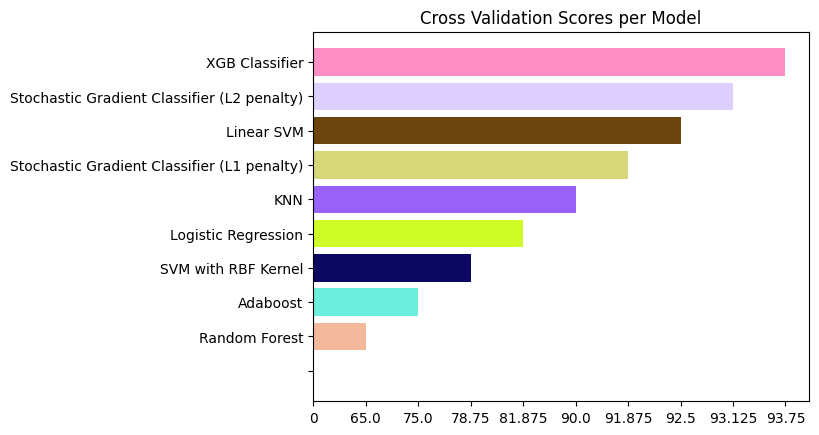

In [169]:
arr = np.array(sorted(list(zip(accuracies, classifiers))))

plt.barh(y=arr[:,1], width=arr[:,0], color=np.random.rand(15, 3))
plt.title("Cross Validation Scores per Model")
plt.show()

</br></br>

### Deep NN Model Creation and Training


In [170]:
preprocessed = corpus['Email'].apply(text_preprocessor.preprocess)
tokens = preprocessed.apply(text_preprocessor.tokenize)

In [171]:
X_train, X_val, X_test, y_train, y_val, y_test = split(tokens,
                                                       corpus['Status'])

In [172]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=200)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=200)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=200)

In [173]:
def EvalNN(X_train, y_train, X_test, y_test, model):
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                             patience=3)

  history = model.fit(X_train, y_train.values,
                    epochs=20,
                    validation_data=(X_val, y_val.values),
                    callbacks=[early_stopping])

  return model.evaluate(X_val, y_val.values)[1] * 100

In [174]:
embedding_layer = tf.keras.layers.Embedding(
  embedding_matrix.shape[0],
  embedding_matrix.shape[1],
  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
  input_length=200,
  trainable=True
)

In [178]:
ANN = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l1'),
    tf.keras.layers.Dense(3, activation='softmax')
])


LSTM = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None),
    tf.keras.layers.Dense(3, activation='softmax')
])


Stacked_LSTM = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                    return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,
                                    return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None),
    tf.keras.layers.Dense(3, activation='softmax')
])


GRU = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None),
    tf.keras.layers.Dense(3, activation='softmax')
])


Stacked_GRU = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,
                                    return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16,
                                return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(8)),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None),
    tf.keras.layers.Dense(3, activation='softmax')
])


CNN = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
NNclassifiers = ['ANN', 'LSTM', 'Stacked LSTM', 'GRU', 'Stacked GRU',
                                                            'CNN', '']

NNaccuracies = [EvalNN(X_train, y_train, X_val, y_val, ANN),
                EvalNN(X_train, y_train, X_val, y_val, LSTM),
                EvalNN(X_train, y_train, X_val, y_val, Stacked_LSTM),
                EvalNN(X_train, y_train, X_val, y_val, GRU),
                EvalNN(X_train, y_train, X_val, y_val, Stacked_GRU),
                EvalNN(X_train, y_train, X_val, y_val, CNN), 0]

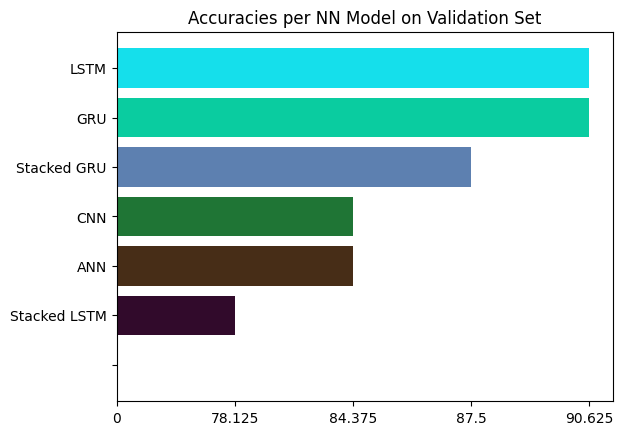

In [180]:
arr = np.array(sorted(list(zip(NNaccuracies, NNclassifiers))))

plt.barh(y=arr[:,1], width=arr[:,0], color=np.random.rand(15, 3))
plt.title("Accuracies per NN Model on Validation Set")
plt.show()